In [1]:
import pandas as pd
import csv
import os
import networkx as nx
import math
from __future__ import division
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (21, 14)
from networkx.algorithms import bipartite as bi


### X.X. Get the data

In [2]:
## first get the table of physician ID data (this is filtered from Medicare at http://bit.ly/2dMgBIr)
npi = pd.read_csv("npidata_20050523-20161009-csv.csv")

In [3]:
npi.head()

,NPI,Last Name,First Name,Gender,Credential,Primary specialty,City,State,Zip Code,Hospital affiliation CCN 1,Hospital affiliation LBN 1
0,1285616490,LAL,GARIMA,F,MD,OPHTHALMOLOGY,PEMBROKE PINES,FL,330292810,NaN,NaN
1,1104865484,STANGHERLIN,MICHAEL,M,DC,CHIROPRACTIC,TEMPLE TERRACE,FL,336176214,NaN,NaN
2,1285601591,MASON,PETER,M,NaN,PODIATRY,LARGO,FL,337712459,NaN,NaN
3,1942385307,TAYLOR,DAVID,M,NaN,CHIROPRACTIC,FORT MYERS,FL,339085307,NaN,NaN
4,1063475176,KOENIGSBERG,ADAM,M,NaN,OPHTHALMOLOGY,JACKSONVILLE,FL,322161110,NaN,NaN


In [4]:
npi = npi.drop(npi.columns[[9,10]], axis=1)

In [5]:
npi = npi.drop_duplicates()
len(npi)

71968

In [6]:
npi.head()

,NPI,Last Name,First Name,Gender,Credential,Primary specialty,City,State,Zip Code
0,1285616490,LAL,GARIMA,F,MD,OPHTHALMOLOGY,PEMBROKE PINES,FL,330292810
1,1104865484,STANGHERLIN,MICHAEL,M,DC,CHIROPRACTIC,TEMPLE TERRACE,FL,336176214
2,1285601591,MASON,PETER,M,NaN,PODIATRY,LARGO,FL,337712459
3,1942385307,TAYLOR,DAVID,M,NaN,CHIROPRACTIC,FORT MYERS,FL,339085307
4,1063475176,KOENIGSBERG,ADAM,M,NaN,OPHTHALMOLOGY,JACKSONVILLE,FL,322161110


In [7]:
## make a list of unique Florida doctor ideas to filter the referral list
fla_docs = pd.Series(npi['NPI'])
fla_docs = fla_docs.unique()

In [8]:
## get the table of referrals from Medicare at http://bit.ly/2dczDBD
refs = pd.read_csv("physician-shared-patient-patterns-2015-days30.txt", header=None, names=['DocA', 'DocB', 'Refs', 'Patients', 'SameDay'])

In [9]:
refs.head()

,DocA,DocB,Refs,Patients,SameDay
0,1000026017,1598773715,56,23,29
1,1000310429,1144645573,68,12,36
2,1003000126,1003951625,147,53,28
3,1003000126,1003975400,38,18,0
4,1003000126,1013051119,30,15,0


In [10]:
## filter out referring physicians who aren't in Florida
refs2 = refs[refs['DocA'].isin(fla_docs)]

In [11]:
## get rid of the old db
del refs

In [12]:
## leaves 41,916 referring docs in the florida data
len(refs2['DocA'].unique())

41916

In [13]:
## they are referring to 94,735 other docs
len(refs2['DocB'].unique())

94735

In [14]:
print ''
for col in refs2:
    print "%-10s: %s" % (col, refs2[col].dtypes)


DocA      : int64
DocB      : int64
Refs      : int64
Patients  : int64
SameDay   : int64


In [15]:
print ''
for col in npi:
    print "%-18s    : %s" % (col, npi[col].dtypes)


NPI                   : int64
Last Name             : object
First Name            : object
Gender                : object
Credential            : object
Primary specialty     : object
City                  : object
State                 : object
Zip Code              : object


In [18]:
## merge the two tables with a left join
refs3 = pd.merge(refs2, npi, how='left', left_on='DocA', right_on='NPI')

In [19]:
refs3.head()

,DocA,DocB,Refs,Patients,SameDay,NPI,Last Name,First Name,Gender,Credential,Primary specialty,City,State,Zip Code
0,1003000522,1003925173,42,14,0,1003000522,WEIGAND,FREDERICK,M,NaN,FAMILY PRACTICE,ORANGE CITY,FL,327638360
1,1003000522,1023058351,49,11,2,1003000522,WEIGAND,FREDERICK,M,NaN,FAMILY PRACTICE,ORANGE CITY,FL,327638360
2,1003000522,1033118955,70,11,2,1003000522,WEIGAND,FREDERICK,M,NaN,FAMILY PRACTICE,ORANGE CITY,FL,327638360
3,1003000522,1073564910,56,16,2,1003000522,WEIGAND,FREDERICK,M,NaN,FAMILY PRACTICE,ORANGE CITY,FL,327638360
4,1003000522,1083617856,48,14,0,1003000522,WEIGAND,FREDERICK,M,NaN,FAMILY PRACTICE,ORANGE CITY,FL,327638360


In [20]:
## duplicates check
refs3[(refs3['DocA'] == 1003000522) & (refs3['DocB'] == 1003925173)]

,DocA,DocB,Refs,Patients,SameDay,NPI,Last Name,First Name,Gender,Credential,Primary specialty,City,State,Zip Code
0,1003000522,1003925173,42,14,0,1003000522,WEIGAND,FREDERICK,M,NaN,FAMILY PRACTICE,ORANGE CITY,FL,327638360


In [21]:
## duplicates check
sorted(refs3.duplicated(), reverse=True)[0:3]

[False, False, False]

In [22]:
## find a city that's not too big
refs3['City'].value_counts()

MIAMI               204599
JACKSONVILLE        199750
TAMPA               191369
BOCA RATON          156425
ORLANDO             136290
NAPLES              118740
FORT MYERS          114401
OCALA                96817
DELRAY BEACH         96165
SARASOTA             77775
BOYNTON BEACH        77084
FORT LAUDERDALE      71888
LARGO                68454
WEST PALM BEACH      67956
CLEARWATER           63344
VENICE               62794
PORT CHARLOTTE       62250
GAINESVILLE          60279
MAITLAND             55913
PENSACOLA            55652
SAINT PETERSBURG     54152
HOLLYWOOD            52411
ST PETERSBURG        48497
MELBOURNE            48467
LAKELAND             47739
BRADENTON            43051
PANAMA CITY          42232
ATLANTIS             39017
CAPE CORAL           38552
BRANDON              38454
                     ...  
SANIT AUGUSTINE          4
PIERSON                  4
BOKEELIA                 4
SW RANCHES               3
WEST PARK                3
OPALOCKA                 3
H

In [23]:
venice = refs3[refs3['City']=='VENICE']
len(venice)

62794

In [6]:
#Loading the Venice, Florida Data without loading the whole data set
venice = pd.read_csv('d:/data/data620/venice.csv', index_col = 0) # Erik Read Data Statement
len(venice)

62794

In [7]:
venice.head()

,DocA,DocB,Refs,Patients,SameDay,NPI,Last Name,First Name,Gender,Credential,Primary specialty,City,State,Zip Code
5974,1003103706,1043475668,42,20,15,1003103706,VINTAYEN,ENRICO,M,NaN,NEUROLOGY,VENICE,FL,342852612
5975,1003103706,1043475668,42,20,15,1003103706,VINTAYEN,ENRICO,M,NaN,NEUROLOGY,VENICE,FL,342852425
5976,1003103706,1043475668,42,20,15,1003103706,VINTAYEN,ENRICO,M,NaN,NEUROLOGY,VENICE,FL,342853568
5977,1003103706,1043475668,42,20,15,1003103706,VINTAYEN,ENRICO,M,NaN,NEUROLOGY,VENICE,FL,342852624
5978,1003103706,1043475668,42,20,15,1003103706,VINTAYEN,ENRICO,M,NaN,NEUROLOGY,VENICE,FL,342852821


In [17]:
venice['Refs'].median()

60.0

In [8]:
venice['Refs'].max()

8749

In [11]:
venice.loc[venice['Refs'] == venice['Refs'].max()]

,DocA,DocB,Refs,Patients,SameDay,NPI,Last Name,First Name,Gender,Credential,Primary specialty,City,State,Zip Code
3433655,1801898614,1588636831,8749,159,0,1801898614,GRIFFIN,VIVIAN,F,NaN,RADIATION ONCOLOGY,VENICE,FL,342853668


### Limiting the Data Set to Two Node Types

The folloing code limits the edge set of the venice data set to only doctors that referr patients and those that recieve patients from these referals.

In [16]:
DocA_list = set(venice.DocA.unique())
DocB_list = set(venice.DocB.unique())
print len(DocA_list), len(DocB_list)
#Docs = list(team1_list.union(team2_list))
#len(teams)

356 5691


In [45]:
pcp = list(set(DocA_list) - set(DocB_list))

In [49]:
primary_care = venice[venice['DocA'].isin(pcp)]

### Looking at the Primary Care Graph

In [51]:
## make a basic undirected graph
P = nx.from_pandas_dataframe(primary_care, 'DocA', 'DocB', ['Refs', 'Patients', 'First Name', 'Gender'])

In [52]:
## utility function to get topmost nodes for each centrality function
def get_top_keys(dictionary, top):
    items = dictionary.items()
    items.sort(reverse=True, key=lambda x: x[1])
    return map(lambda x: x, items[:top])

In [54]:
# Betweenness centrality
bet_cen = nx.betweenness_centrality(P)

# Degree centrality
deg_cen = nx.degree_centrality(P)

# Closeness centrality
clo_cen = nx.closeness_centrality(P)

# Eigenvector centrality
eig_cen = nx.eigenvector_centrality_numpy(P)

In [55]:
## get the top nodes
top_bet_cen = get_top_keys(bet_cen,10)
top_clo_cen = get_top_keys(clo_cen,10)
top_eig_cen = get_top_keys(eig_cen,10)
top_deg_cen = get_top_keys(deg_cen,10)

In [57]:
## smush them together to make a comparison chart
smush = np.hstack((top_bet_cen, top_clo_cen, top_eig_cen, top_deg_cen))

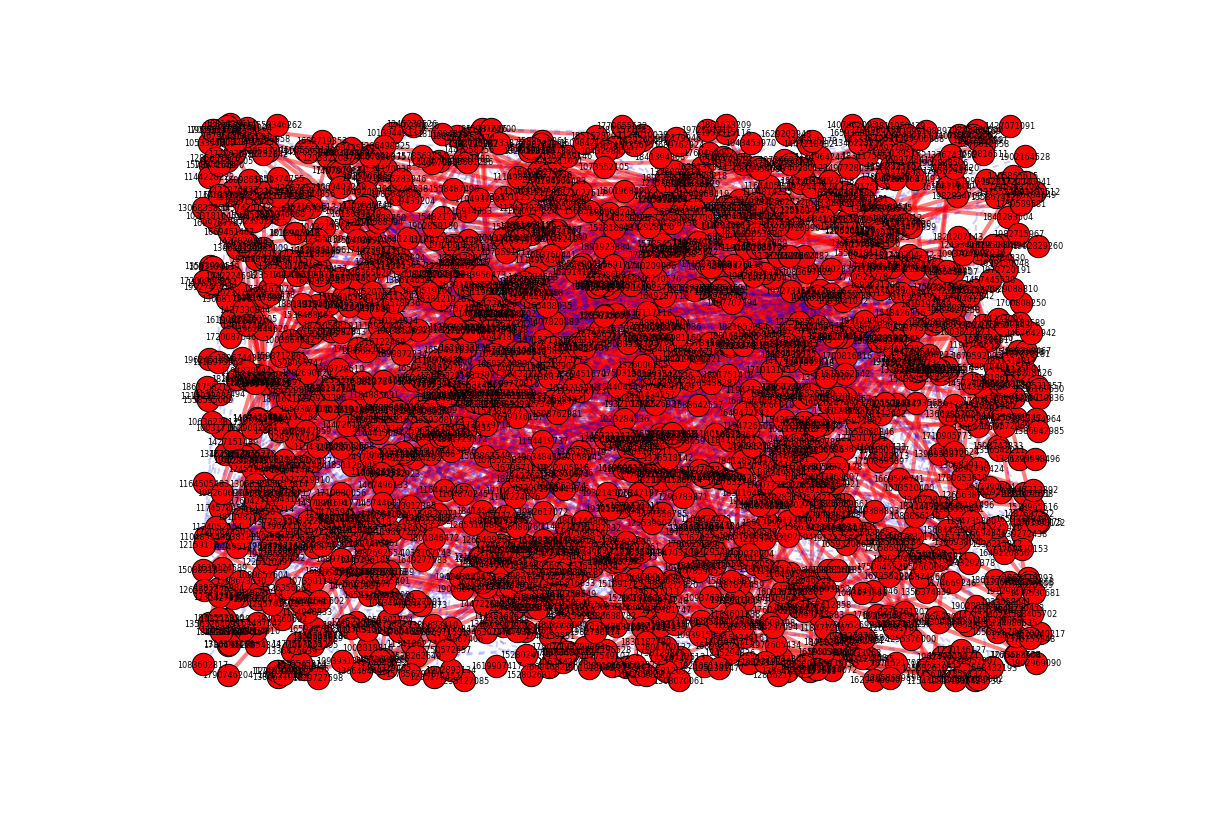

In [58]:
## plot the overall network of referrals
pos=nx.random_layout(G) # positions for all nodes

elarge=[(u,v) for (u,v,d) in P.edges(data=True) if d['Refs'] >60]
esmall=[(u,v) for (u,v,d) in P.edges(data=True) if d['Refs'] <=60]

# nodes
nx.draw_networkx_nodes(P,pos,node_size=500)
# edges
nx.draw_networkx_edges(P,pos,edgelist=elarge, width=4,alpha=0.5,edge_color='r',style='solid')
nx.draw_networkx_edges(P,pos,edgelist=esmall, width=2,alpha=0.2,edge_color='b',style='dashed')

# labels
nx.draw_networkx_labels(P,pos,font_size=8,font_family='sans-serif')

plt.axis('off')
plt.show()

### Looking at the entire Graph

In [12]:
## make a basic undirected graph
G = nx.from_pandas_dataframe(venice, 'DocA', 'DocB', ['Refs', 'Patients', 'First Name', 'Gender'])

In [13]:
## utility function to get topmost nodes for each centrality function
def get_top_keys(dictionary, top):
    items = dictionary.items()
    items.sort(reverse=True, key=lambda x: x[1])
    return map(lambda x: x, items[:top])

In [14]:
# Betweenness centrality
bet_cen = nx.betweenness_centrality(G)

In [28]:
# Degree centrality
deg_cen = nx.degree_centrality(G)

In [29]:
# Closeness centrality
clo_cen = nx.closeness_centrality(G)

In [30]:
# Eigenvector centrality
eig_cen = nx.eigenvector_centrality_numpy(G)

In [31]:
## get the top nodes
top_bet_cen = get_top_keys(bet_cen,10)
top_clo_cen = get_top_keys(clo_cen,10)
top_eig_cen = get_top_keys(eig_cen,10)
top_deg_cen = get_top_keys(deg_cen,10)

In [32]:
## smush them together to make a comparison chart
smush = np.hstack((top_bet_cen, top_clo_cen, top_eig_cen, top_deg_cen))

In [34]:
cent_measures=pd.DataFrame(smush, columns=['Node', 'Betweenness', 'Node', 'Closeness', 'Node', 'Eigenvector', 'Node', 'Degree'])

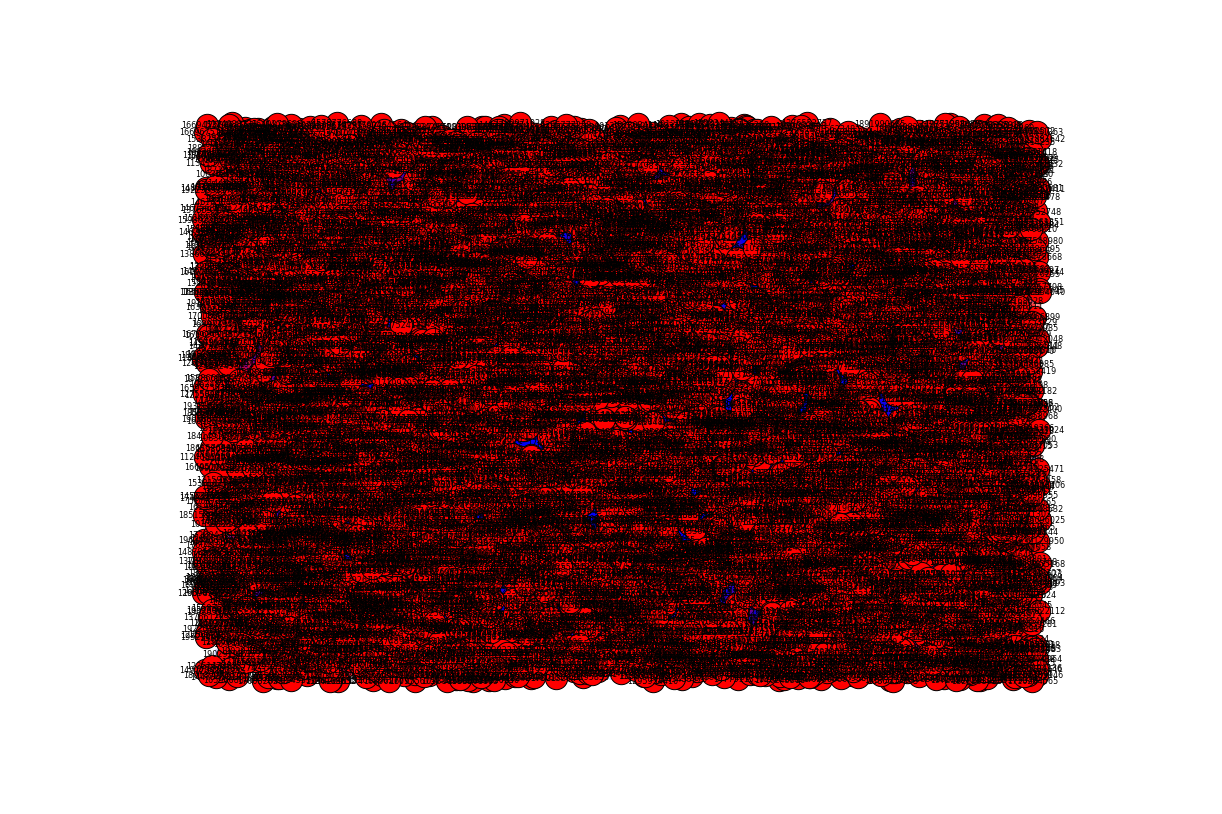

In [43]:
## plot the overall network of referrals
pos=nx.random_layout(G) # positions for all nodes

elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['Refs'] >60]
esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['Refs'] <=60]

# nodes
nx.draw_networkx_nodes(G,pos,node_size=500)
# edges
nx.draw_networkx_edges(G,pos,edgelist=elarge, width=4,alpha=0.5,edge_color='r',style='solid')
nx.draw_networkx_edges(G,pos,edgelist=esmall, width=2,alpha=0.2,edge_color='b',style='dashed')

# labels
nx.draw_networkx_labels(G,pos,font_size=8,font_family='sans-serif')

plt.axis('off')
plt.show()

In [46]:
pd.DataFrame_to_csv(venice, 'venice.csv')

AttributeError: 'module' object has no attribute 'DataFrame_to_csv'